In [ ]:
import seaborn as sns
import ast
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import math
import itertools
import json
import numpy as np
import os
import os.path as path

sns.set(font="DejaVu Sans", context="paper", style="whitegrid", font_scale=2)

directory = 'results'

# VTAB Results Public

In [ ]:
vtab_df_public = pd.read_csv(path.join('vtab-results', "vtab_results_public_summary.csv"))
vtab_df_public

,snoopy
0,-0.395542
1,-0.075111
2,0.165764
3,0.175145
4,-0.248706
5,0.048540
6,0.030249
7,0.075999
8,-0.033100
9,0.093429


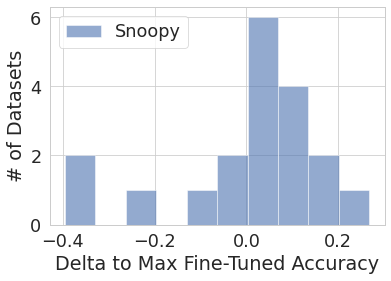

In [ ]:
plt.hist(vtab_df_public['snoopy'].tolist(), 10, facecolor='C0', alpha=0.6, label='Snoopy')
plt.xlabel('Delta to Max Fine-Tuned Accuracy')
plt.ylabel('# of Datasets')
plt.legend()
plt.savefig("{}.png".format('vtab_public'), bbox_inches = 'tight', pad_inches = 0.02)

# Create Pandas DF

## Functions and other data used

In [ ]:
def ber(nn_err: float, c: int) -> float:
    value_to_sqrt = 1 - (c / (c - 1)) * nn_err
    if value_to_sqrt < 0.0:
        value_to_sqrt = 0.0
    return nn_err / (1 + np.sqrt(value_to_sqrt))

In [ ]:
num_classes = {
    "mnist": 10,
    "cifar10": 10,
    "cifar100": 100,
    "imdb_reviews": 2,
    "sst2": 2,
    "yelp": 5,
}

dataset_size = {
    "mnist": 70000,
    "cifar10": 60000,
    "cifar100": 60000,
    "imdb_reviews": 50000,
    "sst2": 67872,
    "yelp": 550000,
}

test_size = {
    "mnist": 10000,
    "cifar10": 10000,
    "cifar100": 10000,
    "imdb_reviews": 25000,
    "sst2": 872,
    "yelp": 50000,
}

sota = {
    "cifar10": 0.005,
    "cifar100": 0.0392,
    "mnist": 0.0016,
    # "yelp": 0.278,
    "yelp": 0.258,
    "imdb_reviews": 0.0379,
    "sst2": 0.032,
}

modality = {
    "mnist": "CV",
    "cifar10": "CV",
    "cifar100": "CV",
    "imdb_reviews": "NLP",
    "sst2": "NLP",
    "yelp": "NLP",
}

cifar10n = [
    "cifar10-aggre",
    "cifar10-random1",
    "cifar10-random2",
    "cifar10-random3",
    "cifar10-worst",
    "cifar100-noisy",
]

mapping_real_noisy = {
    "cifar10-aggre": "cifar10",
    "cifar10-random1": "cifar10",
    "cifar10-random2": "cifar10",
    "cifar10-random3": "cifar10",
    "cifar10-worst": "cifar10",
    "cifar100-noisy": "cifar100",
}

noise_rates = {
    "cifar10-aggre": 0.0903,
    "cifar10-random1": 0.1723,
    "cifar10-random2": 0.1812,
    "cifar10-random3": 0.1764,
    "cifar10-worst": 0.4021,
    "cifar100-noisy": 0.4020,
}

diag_max = {
    "cifar10-aggre": 0.17,
    "cifar10-random1": 0.26,
    "cifar10-random2": 0.26,
    "cifar10-random3": 0.26,
    "cifar10-worst": 0.51,
    "cifar100-noisy": 0.854,
}

diag_min = {
    "cifar10-aggre": 0.03,
    "cifar10-random1": 0.10,
    "cifar10-random2": 0.10,
    "cifar10-random3": 0.10,
    "cifar10-worst": 0.28,
    "cifar100-noisy": 0.083,
}

nondiag_min = {
    "cifar10-aggre": 0.1,
    "cifar10-random1": 0.23,
    "cifar10-random2": 0.23,
    "cifar10-random3": 0.23,
    "cifar10-worst": 0.56,
    "cifar100-noisy": 0.312,
}

### Times for Snoopy

In [ ]:
times_snoopy = {
    "cifar10": 0.2965,
    "cifar100": 0.3405,
    "mnist": 0.1510,
    "yelp": 8.0325,
    "imdb_reviews": 0.7661,
    "sst2": 0.8373,
}

### Times for Running Inference

In [ ]:
times_unoptimized = {
    "cifar10": 1.8933,
    "cifar100": 1.9499,
    "mnist": 2.3451,
    "yelp": 45.0383,
    "imdb_reviews": 4.7875,
    "sst2": 4.6079,
}

## Add 1NN, Snoopy, SOTA and Lowerbound

In [ ]:
columns = ["dataset", "noise", "method", "value", 'time', 'time_warmstart']
rows = []

with open(path.join(directory, "errors_data.txt"), "r") as f:
    data = eval(f.read())

embeddings_per_dataset = {}

for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      num_classes_ = num_classes[dataset]
      sota_ = sota[dataset]
      max_c = (num_classes_ - 1) / float(num_classes_)

      upper_bound = sota_ + noise_level * (max_c - sota_)
      lower_bound = noise_level * max_c

      rows.append([dataset, noise_level, "lowerbound", lower_bound])
      rows.append([dataset, noise_level, "sota", upper_bound])

      current = data[dataset]
      best_1nn = min(
          [
              (embedding, current[embedding]["test"][str(noise_level)]["1-NN cosine"][0])
              for embedding in current
          ],
          key=lambda x: x[1],
      )
      best_1nn_score = ber(best_1nn[1], num_classes_)

      embeddings_per_dataset[dataset] = list(current.keys())

      rows.append([dataset, noise_level, "1nn", best_1nn[1], times_snoopy[dataset], 0])
      rows.append([dataset, noise_level, "snoopy", best_1nn_score, times_snoopy[dataset], 0])

      # if 'raw' in current.keys():
      #   raw_1nn = current['raw']["test"][str(noise_level)]["1-NN cosine"][0]
      #   raw_1nn_score = ber(raw_1nn, num_classes_)
      #   rows.append([dataset, noise_level, "1nn-raw", raw_1nn, 0, 0])
      #   rows.append([dataset, noise_level, "snoopy-raw", raw_1nn_score, 0, 0])

### Add Snoopy and Bounds for CIFAR-N

In [ ]:
df_cifarn = pd.read_csv(path.join(directory, "results-cifar-n.csv"))
df_cifarn.drop(columns=df_cifarn.columns[0], 
               axis=1,
               inplace=True)
df_cifarn["results"] = df_cifarn.results.apply(lambda x: float(x[1:-1].split(', ')[1]) if x.startswith('[') else float(x))

for dataset, err in df_cifarn[(df_cifarn.method == 'knn') & (df_cifarn.variant.str.endswith('k=1'))].groupby(['dataset'])['results'].min().iteritems():
  time = times_snoopy['cifar10'] if dataset.startswith('cifar10-') else times_snoopy['cifar100']
  time_warmstart = 0
  rows.append([dataset, 0.0, "snoopy", err, time, time_warmstart])

## Add Linear

In [ ]:
with open(path.join(directory, "errors_linear.txt"), "r") as f:
    data = eval(f.read())

time_cifar10 = 0.0
time_warmstart_cifar10 = 0.0
time_cifar100 = 0.0
time_warmstart_cifar100 = 0.0

for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      num_classes_ = num_classes[dataset]
      current = data[dataset]

      best_linear = min(
          [
              (embedding, min([sum(v['errors'])/float(len(v['errors'])) for k, v in current[embedding][str(noise_level)].items()]))
              for embedding in current
          ],
          key=lambda x: x[1],
      )
      avg_time = np.average(
          [
            np.average([sum(v['times'])/(float(len(v['times'])))
                 for k, v in current[embedding][str(noise_level)].items()])*9/20.
            for embedding in current
          ]
      )*len(embeddings_per_dataset[dataset])/float(60*60)
      rows.append([dataset, noise_level, "linear", best_linear[1], avg_time + times_unoptimized[dataset]*.8, avg_time])

      if dataset == 'cifar10' and noise_level == 0.0:
        time_cifar10 = avg_time + times_unoptimized[dataset]*.8
        time_warmstart_cifar10 = avg_time

      if dataset == 'cifar100' and noise_level == 0.0:
        time_cifar100 = avg_time + times_unoptimized[dataset]*.8
        time_warmstart_cifar100 = avg_time

      # rows.append([dataset, noise_level, "linear-frac", best_linear[1]*0.8, avg_time + times_unoptimized[dataset]*.8, avg_time])
      # rows.append([dataset, noise_level, "linear-ber", ber(best_linear[1], num_classes_), avg_time + times_unoptimized[dataset]*.8, avg_time])

### Add Linear for CIFAR-N

In [ ]:
for dataset, err in df_cifarn[df_cifarn.method == 'lr_model'].groupby(['dataset'])['results'].min().iteritems():
  time = time_cifar10 if dataset.startswith('cifar10-') else time_cifar100
  time_warmstart = time_warmstart_cifar10 if dataset.startswith('cifar10-') else time_warmstart_cifar100
  rows.append([dataset, 0.0, "linear", err, time, time_warmstart])

## Add FineTune

In [ ]:
with open(path.join(directory, "errors_finetune.txt"), "r") as f:
    data = eval(f.read())

for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      if dataset not in data.keys() or str(noise_level) not in data[dataset].keys():
        rows.append([dataset, noise_level, "finetune", None, None])
      else:
        factor = 3*3 if dataset in modality.keys() and modality[dataset] == 'NLP' else 1.0
        rows.append([dataset, noise_level, 
                     "finetune", data[dataset][str(noise_level)]['error'], 
                     data[dataset][str(noise_level)]['time']*factor/float(60*60), 
                     data[dataset][str(noise_level)]['time']*factor/float(60*60)])

# Add missing MNIST
for noise_level in [x/10.0 for x in range(11)]:
  rows.append(['mnist', noise_level, "finetune", None, None])

## Add AutoKeras

In [ ]:
with open(path.join(directory, "errors_autokeras.txt"), "r") as f:
    data = eval(f.read())
    
for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      if dataset not in data.keys() or str(noise_level) not in data[dataset].keys():
        rows.append([dataset, noise_level, "autokeras", None])
      else:
        rows.append([dataset, noise_level, 
                     "autokeras", data[dataset][str(noise_level)]['error'], 
                     data[dataset][str(noise_level)]['time']/float(60*60), 
                     data[dataset][str(noise_level)]['time']/float(60*60)])

## Add Auto-sklearn

In [ ]:
with open(path.join(directory, "errors_auto-sklearn_short.txt"), "r") as f:
    data = eval(f.read())
    
for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      if dataset not in data.keys() or str(noise_level) not in data[dataset].keys():
        rows.append([dataset, noise_level, "auto-sklearn (short)", None])
      else:
        rows.append([dataset, noise_level, 
                     "auto-sklearn (short)", data[dataset][str(noise_level)]['error'], 
                     data[dataset][str(noise_level)]['time']/float(60*60), 
                     data[dataset][str(noise_level)]['time']/float(60*60)])

In [ ]:
with open(path.join(directory, "errors_auto-sklearn_long.txt"), "r") as f:
    data = eval(f.read())
    
for dataset in data:
    for noise_level in [x/10.0 for x in range(11)]:
      if dataset not in data.keys() or str(noise_level) not in data[dataset].keys():
        rows.append([dataset, noise_level, "auto-sklearn (long)", None])
      else:
        rows.append([dataset, noise_level, 
                     "auto-sklearn (long)", data[dataset][str(noise_level)]['error'], 
                     data[dataset][str(noise_level)]['time']/float(60*60), 
                     data[dataset][str(noise_level)]['time']/float(60*60)])

## Create dataframe

In [ ]:
df = pd.DataFrame(data=rows, columns=columns)
df

,dataset,noise,method,value,time,time_warmstart
0,cifar10,0.00,lowerbound,0.00,NaN,NaN
1,cifar10,0.00,sota,0.01,NaN,NaN
2,cifar10,0.00,1nn,0.10,0.30,0.00
3,cifar10,0.00,snoopy,0.05,0.30,0.00
4,cifar10,0.10,lowerbound,0.09,NaN,NaN
...,...,...,...,...,...,...
865,yelp,0.60,auto-sklearn (long),NaN,NaN,NaN
866,yelp,0.70,auto-sklearn (long),NaN,NaN,NaN
867,yelp,0.80,auto-sklearn (long),NaN,NaN,NaN
868,yelp,0.90,auto-sklearn (long),NaN,NaN,NaN


## Add AutoML as min AutoKeras/Finetune (disabled for now)

In [ ]:
if False:
  rows = []
  for grp, df_grp in df[df.method.isin(['autokeras', 'finetune'])].groupby(['dataset', 'noise']):
    # print(grp)
    idx = df_grp.value.idxmin()
    if np.isnan(idx):
      rows.append([grp[0], grp[1], "automl", None])
    else:
      rows.append([grp[0], grp[1], "automl", df_grp.loc[idx].value])

  df = pd.concat([df, pd.DataFrame(data=rows, columns=columns)])
  df

# Theoretical Justifications (moved to FeeBee Analysis colab)

In [ ]:
# dataset='cifar10'
# methods=['snoopy', '1nn', 'snoopy-raw', '1nn-raw', 'sota']

# df_filtered = df[(df.dataset == 'cifar100') & 
#                  (df.method.isin(methods))]

# sns.lineplot(data=df_filtered, x='noise', y='value', hue='method')

In [ ]:
# dataset='cifar10'
# methods=['linear-frac', 'linear-ber', 'linear', 'sota']

# df_filtered = df[(df.dataset == 'cifar100') & 
#                  (df.method.isin(methods))]

# sns.lineplot(data=df_filtered, x='noise', y='value', hue='method')

# Conceptual contributon: Feasibility Study

## Snoopy vs Baselines

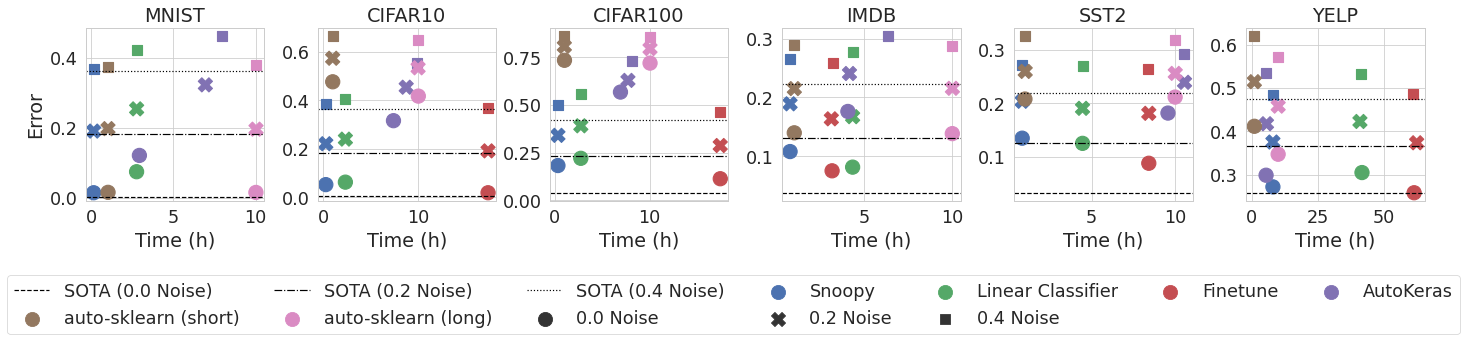

In [ ]:
noise_levels = [0.0, 0.2, 0.4]
exclude_method = ['1nn']
FLAG_PLOT_SOTA = True

method_mapping = {
      'snoopy': 'Snoopy',
      '1nn': '1NN Classifier',
      'linear': 'Linear Classifier',
      'finetune': 'Finetune',
      'autokeras': 'AutoKeras',
      'auto-sklearn (short)': 'auto-sklearn (short)',
      'auto-sklearn (long)': 'auto-sklearn (long)',
  }
def readble_method(method):
  return method_mapping[method]

palette ={}
for i, m in enumerate(method_mapping.keys()):
  palette[readble_method(m)] = f'C{i}'
  
def flip(items, ncol):
  return itertools.chain(*[items[i::ncol] for i in range(ncol)])

f, axes = plt.subplots(1, 6, figsize=(24, 5))
counter = 0

for dataset in modality.keys():
  grp = df[(~df.method.isin(exclude_method)) & 
           (df.noise.isin(noise_levels)) & 
           (df.time.notna()) & 
           (df.dataset == dataset)].copy()

  ax = axes.flat[counter]

  grp.method = grp.method.apply(readble_method)
  ax = sns.scatterplot(ax=ax, data=grp, x='time', y='value', hue='method', 
                       style='noise', marker='x', s=200, lw=10,
                       palette=palette)
  ax.set_title(f"{dataset.split('_')[0].upper()}")
  ax.set_xlabel(r"Time (h)")
  if counter == 0:
    ax.set_ylabel("Error")
  else:
    ax.set_ylabel("")


  if FLAG_PLOT_SOTA:
    styles = ['--', '-.', ':']
    for i, noise in enumerate(noise_levels):
      y = sota[dataset] + noise*((num_classes[dataset] - 1.0) / num_classes[dataset] - sota[dataset])
      ax.axhline(y=y, color='black', linestyle=styles[i])
      ax.lines[-1].set_label(f"SOTA ({noise} Noise)")

  counter = counter + 1

handles, lables = axes.flat[1].get_legend_handles_labels()
for h in handles:
  if type(h) is not Line2D:
    h.set_sizes([200.0])
if FLAG_PLOT_SOTA:
  handles = handles[:len(noise_levels)] + handles[len(noise_levels)+1:]
  lables = lables[:len(noise_levels)] + lables[len(noise_levels)+1:]
else:
  handles = handles[1:]
  lables = lables[1:]
handles = handles[:-len(noise_levels)-1] + handles[-len(noise_levels):]
lables = lables[:-len(noise_levels)-1] + [f"{val} Noise" for val in lables[-len(noise_levels):]]

ncol=7
lgd = f.legend(flip(handles, ncol), flip(lables, ncol), loc='lower center', ncol=ncol)

for i, ax in enumerate(axes.flat):
  ax.legend([],[], frameon=False)

plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.4)
save_filename = 'snoopy_baselines'
f.savefig("{}.png".format(save_filename), bbox_inches = 'tight',
            bbox_extra_artists=(lgd,), pad_inches = 0)

## Real Noisy Datasets

In [ ]:
df[(df.dataset.isin(cifar10n)) & (df.noise == 0.0)].dataset.unique()

array(['cifar10-aggre', 'cifar10-random1', 'cifar10-random2',
       'cifar10-random3', 'cifar10-worst', 'cifar100-noisy'], dtype=object)

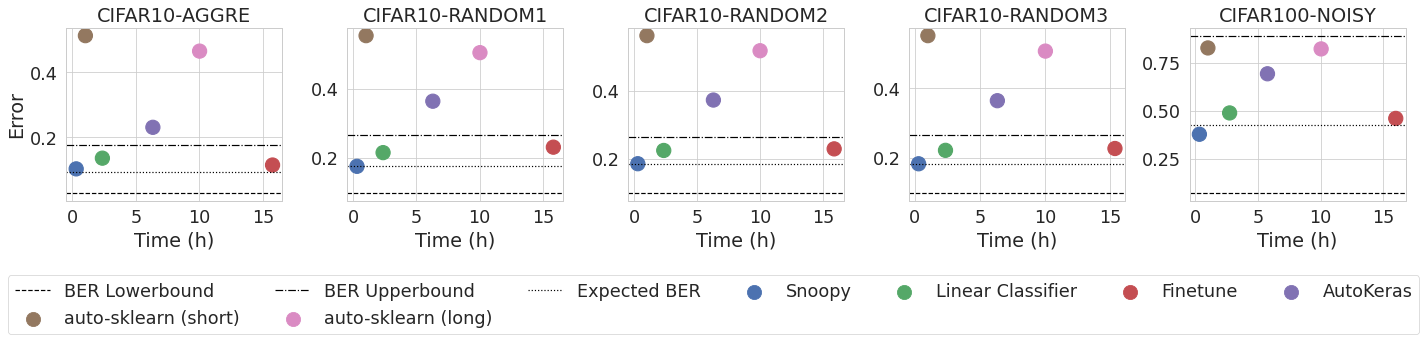

In [ ]:
cnt_noise_levels = 3
exclude_method = ['1nn']
FLAG_PLOT_SOTA = True

method_mapping = {
      'snoopy': 'Snoopy',
      '1nn': '1NN Classifier',
      'linear': 'Linear Classifier',
      'finetune': 'Finetune',
      'autokeras': 'AutoKeras',
      'auto-sklearn (short)': 'auto-sklearn (short)',
      'auto-sklearn (long)': 'auto-sklearn (long)',
  }
def readble_method(method):
  return method_mapping[method]

palette ={}
for i, m in enumerate(method_mapping.keys()):
  palette[readble_method(m)] = f'C{i}'

f, axes = plt.subplots(1, 5, figsize=(24, 5))
counter = 0

for dataset in cifar10n:
  if dataset == 'cifar10-worst':
    continue
  grp = df[(~df.method.isin(exclude_method)) & 
           (df.noise == 0.0) & 
           (df.time.notna()) & 
           (df.dataset == dataset)].copy()

  ax = axes.flat[counter]

  grp.method = grp.method.apply(readble_method)
  ax = sns.scatterplot(ax=ax, data=grp, x='time', y='value', hue='method', 
                       style='noise', marker='x', s=200, lw=10,
                       palette=palette)
  ax.set_title(f"{dataset.split('_')[0].upper()}")
  ax.set_xlabel(r"Time (h)")
  if counter == 0:
    ax.set_ylabel("Error")
  else:
    ax.set_ylabel("")


  if FLAG_PLOT_SOTA:
    styles = ['--', '-.', ':']

    # y = sota[mapping_real_noisy[dataset]] + diag_min[dataset]*(1 - sota[mapping_real_noisy[dataset]])
    y = diag_min[dataset] - (nondiag_min[dataset]*sota[mapping_real_noisy[dataset]])
    ax.axhline(y=y, color='black', linestyle=styles[0])
    ax.lines[-1].set_label(f"BER Lowerbound")

    # y = sota[mapping_real_noisy[dataset]] + diag_max[dataset]*(1 - sota[mapping_real_noisy[dataset]])
    y = diag_max[dataset] + sota[mapping_real_noisy[dataset]]
    ax.axhline(y=y, color='black', linestyle=styles[1])
    ax.lines[-1].set_label(f"BER Upperbound")

    y = sota[mapping_real_noisy[dataset]] + noise_rates[dataset]*(1 - sota[mapping_real_noisy[dataset]])
    ax.axhline(y=y, color='black', linestyle=styles[2])
    ax.lines[-1].set_label(f"Expected BER")

  counter = counter + 1

handles, lables = axes.flat[1].get_legend_handles_labels()
for h in handles:
  if type(h) is not Line2D:
    h.set_sizes([200.0])
if FLAG_PLOT_SOTA:
  handles = handles[:cnt_noise_levels] + handles[cnt_noise_levels+1:]
  lables = lables[:cnt_noise_levels] + lables[cnt_noise_levels+1:]
else:
  handles = handles[1:]
  lables = lables[1:]
handles = handles[:-2]
lables = lables[:-2]

ncol=7
lgd = f.legend(flip(handles, ncol), flip(lables, ncol), loc='lower center', ncol=ncol)

for i, ax in enumerate(axes.flat):
  ax.legend([],[], frameon=False)

plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.4)
save_filename = 'snoopy_real_baselines'
f.savefig("{}.png".format(save_filename), bbox_inches = 'tight',
            bbox_extra_artists=(lgd,), pad_inches = 0)

## End-2-End Label Cleaning

In [ ]:
import random

from sklearn.linear_model import LinearRegression

def inv(target, dataset, method):
  values = df[(df.dataset == dataset) & (df.method == method)][['noise', 'value']]
  u_noise = None
  l_noise = None
  u_error = None
  l_error = None
  for i, row in values.iterrows():
    noise = row['noise']
    error = row['value']
    # print(i, noise, error)
    if error < target:
      if not u_error or u_error < error:
        u_error = error
        u_noise = noise
    if error >= target:
      if not l_error or l_error > error:
        l_error = error
        l_noise = noise
  # print(u, l)
  if u_noise is None:
    return 0.0
  if l_noise is None:
    return 1.0
  return np.interp(target, [u_error, l_error], [u_noise, l_noise])

def clean_random(labels_noisy, labels_cleaned, step):
  # labels_noisy - binary array for each label if noisy or not
  # labels cleaned - binary array for each label if cleaned or not
  # step - number of sampled to clean

  indices = [i for i, x in enumerate(labels_cleaned) if not x]
  picked = random.sample(indices, min(step, len(indices)))
  cnt = 0
  for i in picked:
    if labels_noisy[i]:
      cnt = cnt + 1
    labels_noisy[i] = False
    labels_cleaned[i] = True

  # print("Picked", len(picked), 'Cleaned', cnt)

  return labels_noisy, labels_cleaned, min(step, len(indices)), cnt

def calc_noise(labels_noisy):
  return sum([1 for i in labels_noisy if i])/float(len(labels_noisy))

def automl_fn(dataset, noise):
  lower = math.floor(noise*10)
  upper = lower + 1

  lower = lower/10.
  upper = upper/10.

  automl_df = df[(df.dataset == dataset) & (df.method == 'finetune')]

  return np.interp(noise, [lower, upper], [automl_df[automl_df.noise == lower].iloc[0].value, automl_df[automl_df.noise == upper].iloc[0].value])

In [ ]:
def plot_acc_vs_costs(ax, title, dataset, init_noise, target, machine_dollar, label_dollar, steps=[]):
  
  automl_noise = inv(target, dataset, 'finetune')
  snoopy_noise = inv(target, dataset, 'snoopy')
  knn_noise = inv(target, dataset, '1nn')
  linear_noise = inv(target, dataset, 'linear')

  time_automl = df[(df.dataset == dataset) & (df.method == 'finetune')].time.mean()
  time_snoopy = df[(df.dataset == dataset) & (df.method == 'snoopy')].time.mean()
  time_linear = df[(df.dataset == dataset) & (df.method == 'linear')].time.mean()
  time_linear_warmstart = df[(df.dataset == dataset) & (df.method == 'linear')].time_warmstart.mean()

  # ds_name = dataset.split('_')[0].upper()
  # print(f'Dataset: {ds_name}, init noise: {init_noise:.2f}, target accuracy: {1.0 - target_error:.2f}')
  # print(f'AutoML Target Noise: {automl_noise:.2f}, Avg Comp. Time: {time_automl:.2f}h, ~Min Label Cleaning Costs: {dataset_size[dataset]*(init_noise - automl_noise)*label_dollar:.2f}')
  # print(f'Snoopy Target Noise: {snoopy_noise:.2f}, Avg Comp. Time: {time_snoopy:.2f}h, ~Min Label Cleaning Costs: {dataset_size[dataset]*(init_noise - snoopy_noise)*label_dollar:.2f}')
  # print(f'1NN Target Noise: {knn_noise:.2f}, Avg Comp. Time: {time_snoopy:.2f}h, ~Min Label Cleaning Costs: {dataset_size[dataset]*(init_noise - knn_noise)*label_dollar:.2f}')
  # print(f'Linear Target Noise: {linear_noise:.2f}, Avg Comp. Time: {time_linear:.2f}h (warm: {time_linear_warmstart:.2f}h), ~Min Label Cleaning Costs: {dataset_size[dataset]*(init_noise - linear_noise)*label_dollar:.2f}')

  labels_noisy_init = [False]*dataset_size[dataset]
  labels_cleaned_init = [False]*dataset_size[dataset]

  picked = random.sample(range(0, dataset_size[dataset]), math.ceil(dataset_size[dataset]*init_noise))
  for i in picked:
    labels_noisy_init[i] = True
  
  plt.sca(ax)

  lw_lines = 2
  lw_bounds = 2

  assert automl_noise >= 0
  plt.title(title)

  plt.axhline(y=1.0 - target, color='black', linestyle='--', label="Target Accuracy", linewidth=lw_bounds)

  # Plot lower bound

  labels_noisy = labels_noisy_init[:]
  labels_cleaned = labels_cleaned_init[:]

  if automl_noise < init_noise:
    y = [init_noise, automl_noise]
    x = [0.0, math.ceil((init_noise - automl_noise)*dataset_size[dataset])*label_dollar]
  else:
    y = [init_noise]
    x = [0.0]
  y.append(y[-1])
  x.append(x[-1] + (time_automl * machine_dollar))
  
  y = [1.0 - automl_fn(dataset, v) for v in y]

  max_x = x[-1]

  # plt.plot(x, y, label=None, color='C{}'.format(color_cnt))
  # plt.plot(x[-1], y[-1], 'o', markersize=7, label='Lower Bound', color='C{}'.format(color_cnt))
  # color_cnt = color_cnt+1

  plt.axvline(x=x[-1], color='black', linestyle=':', label="Lower Bound", linewidth=lw_bounds)

  color_cnt = 1

  # Plot knn

  # labels_noisy = labels_noisy_init[:]
  # labels_cleaned = labels_cleaned_init[:]

  # y = [init_noise, init_noise]
  # x = [0.0, time_snoopy * machine_dollar]

  # feasible = knn_noise > init_noise

  # step = math.ceil(dataset_size[dataset]*0.01)

  # while not feasible:
  #   labels_noisy, labels_cleaned, work = clean_random(labels_noisy, labels_cleaned, step)
  #   if work == 0:
  #     break
  #   current_noise = calc_noise(labels_noisy)
  #   y.append(current_noise)
  #   x.append(x[-1] + (work*label_dollar))
  #   feasible = knn_noise > current_noise
  
  # y.append(y[-1])
  # x.append(x[-1] + (time_automl * machine_dollar))
  
  # # y = automl_fn.predict(np.array(y).reshape(-1, 1))
  # y = [1.0 - automl_fn(dataset, v) for v in y]

  # max_x = x[-1]

  # plt.plot(x, y, label=None, color='C{}'.format(color_cnt), lw=lw_lines, linestyle='--')
  # plt.plot(x[-1], y[-1], 'o', markersize=7, label='1NN proxy', color='C{}'.format(color_cnt), lw=lw_lines)

  color_cnt = color_cnt+1

  # Plot linear

  labels_noisy = labels_noisy_init[:]
  labels_cleaned = labels_cleaned_init[:]

  y = [init_noise, init_noise]
  x = [0.0, time_linear * machine_dollar]

  feasible = linear_noise > init_noise

  step = math.ceil(dataset_size[dataset]*0.01)

  rounds = 0
  labels_cleaned_sum = 0

  while not feasible:
    labels_noisy, labels_cleaned, work, cnt = clean_random(labels_noisy, labels_cleaned, step)
    if work == 0:
      break
    rounds = rounds + 1
    labels_cleaned_sum = labels_cleaned_sum + cnt
    current_noise = calc_noise(labels_noisy)
    y.append(current_noise)
    x.append(x[-1] + (work*label_dollar))
    y.append(current_noise)
    x.append(x[-1] + (time_linear_warmstart * machine_dollar))
    feasible = linear_noise > current_noise
  
  y.append(y[-1])
  x.append(x[-1] + (time_automl * machine_dollar))
  
  # y = automl_fn.predict(np.array(y).reshape(-1, 1))
  y = [1.0 - automl_fn(dataset, v) for v in y]

  max_x = x[-1]

  plt.plot(x, y, label=None, color='C{}'.format(color_cnt), lw=lw_lines, linestyle='-.')
  plt.plot(x[-1], y[-1], 'o', markersize=7, label='LR proxy', color='C{}'.format(color_cnt), lw=lw_lines)
  print("LR proxy -- Rounds:", rounds, ", Total Labels Cleaned:", labels_cleaned_sum)

  color_cnt = color_cnt+1

  # AutoML
  
  for s in steps:

    labels_noisy = labels_noisy_init[:]
    labels_cleaned = labels_cleaned_init[:]

    y = [init_noise, init_noise]
    x = [0.0, time_automl * machine_dollar]

    feasible = automl_noise > init_noise

    step = math.ceil(dataset_size[dataset]*s)

    rounds = 0
    labels_cleaned_sum = 0

    while not feasible:
      labels_noisy, labels_cleaned, work, cnt = clean_random(labels_noisy, labels_cleaned, step)
      if work == 0:
        break
      rounds = rounds + 1
      labels_cleaned_sum = labels_cleaned_sum + cnt
      current_noise = calc_noise(labels_noisy)
      y.append(current_noise)
      x.append(x[-1] + (work*label_dollar))
      y.append(current_noise)
      x.append(x[-1] + (time_automl * machine_dollar))
      feasible = automl_noise > current_noise

    # y = automl_fn.predict(np.array(y).reshape(-1, 1))
    y = [1.0 - automl_fn(dataset, v) for v in y]

    real_x = [a for i,a in enumerate(x) if i % 2 == 1 or i == len(x)-1]
    real_y = [a for i,a in enumerate(y) if i % 2 == 1 or i == len(y)-1]

    max_x =max(max_x, real_x[-1])

    plt.plot(x, y, label=None, color='C{}'.format(color_cnt), lw=lw_lines, linestyle=':')
    plt.plot(real_x, real_y, 'o', markersize=7, label='FineTune (Step: {}%)'.format(s*100), color='C{}'.format(color_cnt), lw=lw_lines)

    print("FineTune (Step: {}%)".format(s*100), "-- Rounds:", rounds, ", Total Labels Cleaned:", labels_cleaned_sum)

    color_cnt = color_cnt+1

  # Plot Snoopy

  color_cnt = 0

  labels_noisy = labels_noisy_init[:]
  labels_cleaned = labels_cleaned_init[:]

  y = [init_noise, init_noise]
  x = [0.0, time_snoopy * machine_dollar]

  feasible = snoopy_noise > init_noise

  step = math.ceil(dataset_size[dataset]*0.01)

  rounds = 0
  labels_cleaned_sum = 0

  while not feasible:
    labels_noisy, labels_cleaned, work, cnt = clean_random(labels_noisy, labels_cleaned, step)
    if work == 0:
      break
    rounds = rounds + 1
    labels_cleaned_sum = labels_cleaned_sum + cnt
    current_noise = calc_noise(labels_noisy)
    y.append(current_noise)
    x.append(x[-1] + (work*label_dollar))
    feasible = snoopy_noise > current_noise
  
  y.append(y[-1])
  x.append(x[-1] + (time_automl * machine_dollar))
  
  y = [1.0 - automl_fn(dataset, v) for v in y]

  max_x = x[-1]

  plt.plot(x, y, label=None, color='C{}'.format(color_cnt), lw=lw_lines)
  plt.plot(x[-1], y[-1], 'o', markersize=7, label='Snoopy', color='C{}'.format(color_cnt), lw=lw_lines)
  print("Snoopy", "-- Rounds:", rounds, ", Total Labels Cleaned:", labels_cleaned_sum)

  handles, labels = ax.get_legend_handles_labels()

  # labels = labels[0:2] + [labels[-1]] + labels[2:-1]
  # handles = handles[0:2]
  # for i in range(0,len(labels)-2):
  #   handles.append(Line2D([0], [0], color='C{}'.format(i), marker='o', markersize=7))

  # handles[2].set_data(handles[1].get_data())

  ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
  # ax.legend().set_visible(False)
  # plt.xlim(10**2,10**math.ceil(math.log10(max_x)))
  # plt.ylim(0.5, 1)
  # plt.xscale("log")
  plt.xlabel('Costs ($)')
  plt.ylabel('Accuracy')

### Plot Single

LR proxy -- Rounds: 100 , Total Labels Cleaned: 24000
FineTune (Step: 50.0%) -- Rounds: 2 , Total Labels Cleaned: 24000
FineTune (Step: 10.0%) -- Rounds: 8 , Total Labels Cleaned: 19182
FineTune (Step: 5.0%) -- Rounds: 15 , Total Labels Cleaned: 17945
Snoopy -- Rounds: 95 , Total Labels Cleaned: 22811
LR proxy -- Rounds: 100 , Total Labels Cleaned: 12000
FineTune (Step: 50.0%) -- Rounds: 1 , Total Labels Cleaned: 5998
FineTune (Step: 10.0%) -- Rounds: 5 , Total Labels Cleaned: 5994
FineTune (Step: 5.0%) -- Rounds: 10 , Total Labels Cleaned: 5997
Snoopy -- Rounds: 89 , Total Labels Cleaned: 10714


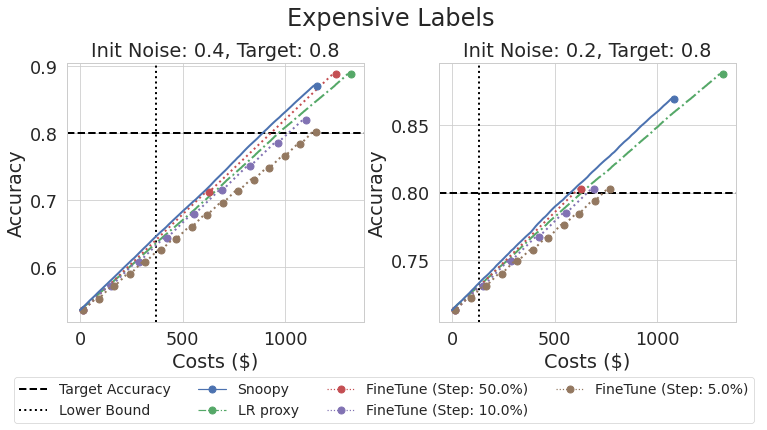

In [ ]:
# label_dollar = 0.008 # at a 5sec/label rate and 6$/hour salary
label_dollar = 0.02  # at a 5sec/label rate (720/hour) and 15$/hour salary
title = 'Expensive Labels'
# label_dollar = 0.002  # at a 0.5sec/label rate (7200/hour) and 15$/hour salary
# title = 'Cheap Labels'
# label_dollar = 0.0
# title = 'Free Labels'
# label_dollar = 0.25 # at a 1min/label rate (60/hour) and 15$/hour salary
# label_dollar = 0. # at a 5sec/label rate and 6$/hour salary

machine_dollar = 0.9 # per hour (one GPU EC2 instance)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dataset = 'cifar100'
init_noise = 0.4
target_error = 0.2

plot_acc_vs_costs(ax1, "Init Noise: {}, Target: {}".format(init_noise, 1-target_error), dataset, init_noise, target_error, machine_dollar, label_dollar, steps=[0.5, 0.1, 0.05])
init_noise = 0.2
target_error = 0.2
plot_acc_vs_costs(ax2, "Init Noise: {}, Target: {}".format(init_noise, 1-target_error), dataset, init_noise, target_error, machine_dollar, label_dollar, steps=[0.5, 0.1, 0.05])

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

handles, labels = ax1.get_legend_handles_labels()

labels = labels[0:2] + [labels[-1]] + labels[2:-1]
handles = handles[0:2]
handles.append(Line2D([0], [0], color='C0', marker='o', markersize=7))
# handles.append(Line2D([0], [0], color='C1', marker='o', markersize=7, ls='--'))
handles.append(Line2D([0], [0], color='C2', marker='o', markersize=7, ls='-.'))
for i in range(3,len(labels)):
  handles.append(Line2D([0], [0], color='C{}'.format(i), marker='o', markersize=7, ls=':'))

f.suptitle(title, fontsize=24)
f.legend(handles, labels, loc='lower center', ncol=4, prop={'size':14})
plt.subplots_adjust(top=0.85, wspace=0.25, bottom=0.25)

### Plot and save all

In [ ]:
plot_configs = {
    'cifar10': [(0.4, 0.2), (0.2, 0.1)],
    'cifar100': [(0.4, 0.4), (0.2, 0.2)],
    'imdb_reviews': [(0.4, 0.2), (0.2, 0.1)],
    'sst2': [(0.4, 0.2), (0.2, 0.1)],
    'yelp': [(0.4, 0.4), (0.2, 0.3)],
}

label_configs = {
    'Free Labels': 0.0,
    'Cheap Labels': 0.002,
    'Expensive Labels': 0.02
}

save_directory = 'end2end_figures'
if not os.path.exists(save_directory):
  os.mkdir(save_directory)

for dataset in plot_configs.keys():
  for title, label_dollar in label_configs.items():
    save_filename = "{}_end2end_{}".format(dataset.split('_')[0], title.lower().replace(' ', '_'))
    print('Processing', save_filename)

    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, (init_noise, target_error) in enumerate(plot_configs[dataset]):
      ax = axes[i]
      plot_acc_vs_costs(ax, f"Init Noise: {init_noise:.2f}, Target: {1-target_error:.2f}", dataset, init_noise, target_error, machine_dollar, label_dollar, steps=[0.5, 0.1, 0.05])
      ax.legend().set_visible(False)

    handles, labels = ax1.get_legend_handles_labels()

    labels = labels[0:2] + [labels[-1]] + labels[2:-1]
    handles = handles[0:2]
    handles.append(Line2D([0], [0], color='C0', marker='o', markersize=7))
    # handles.append(Line2D([0], [0], color='C1', marker='o', markersize=7, ls='--'))
    handles.append(Line2D([0], [0], color='C2', marker='o', markersize=7, ls='-.'))
    for i in range(3,len(labels)):
      handles.append(Line2D([0], [0], color='C{}'.format(i), marker='o', markersize=7, ls=':'))

    dsname = dataset.split('_')[0].upper()
    # f.suptitle(f"{dsname} - {title}", fontsize=24)
    f.legend(handles, labels, loc='lower center', ncol=4, prop={'size':14})
    plt.subplots_adjust(top=0.85, wspace=0.25, bottom=0.25)
    f.savefig("{}/{}.png".format(save_directory, save_filename), bbox_inches = 'tight', pad_inches = 0.02)
    plt.close()

Processing cifar10_end2end_free_labels
LR proxy -- Rounds: 61 , Total Labels Cleaned: 14773
FineTune (Step: 50.0%) -- Rounds: 1 , Total Labels Cleaned: 11936
FineTune (Step: 10.0%) -- Rounds: 5 , Total Labels Cleaned: 12022
FineTune (Step: 5.0%) -- Rounds: 10 , Total Labels Cleaned: 12047
Snoopy -- Rounds: 56 , Total Labels Cleaned: 13454
LR proxy -- Rounds: 79 , Total Labels Cleaned: 9494
FineTune (Step: 50.0%) -- Rounds: 2 , Total Labels Cleaned: 12000
FineTune (Step: 10.0%) -- Rounds: 6 , Total Labels Cleaned: 7177
FineTune (Step: 5.0%) -- Rounds: 11 , Total Labels Cleaned: 6608
Snoopy -- Rounds: 70 , Total Labels Cleaned: 8433
Processing cifar10_end2end_cheap_labels
LR proxy -- Rounds: 62 , Total Labels Cleaned: 14773
FineTune (Step: 50.0%) -- Rounds: 1 , Total Labels Cleaned: 12056
FineTune (Step: 10.0%) -- Rounds: 5 , Total Labels Cleaned: 12016
FineTune (Step: 5.0%) -- Rounds: 10 , Total Labels Cleaned: 12001
Snoopy -- Rounds: 56 , Total Labels Cleaned: 13455
LR proxy -- Rounds:

In [ ]:
# Download end2end_figures
from google.colab import files
# !zip -r /content/end2end_figures.zip /content/end2end_figures/*.png
# files.download("/content/end2end_figures.zip")

# System optimizations

In [ ]:
data = []
columns = ["dataset", "type", "value"]

# for k, v in times_snoopy.items():
for k in modality.keys():
  v = times_snoopy[k]
  data.append([k.split('_')[0].upper(), 'Coldstart', v*60*60*1000])
  # data.append([k, 'SystemX (unoptimized, hours)', times_unoptimized[k]])

  # add incremental time
  data.append([k.split('_')[0].upper(), 'Incremental', len(embeddings_per_dataset[k])*test_size[k]*0.02/(10000)])

df_times = pd.DataFrame(data=data, columns=columns)
df_times

,dataset,type,value
0,MNIST,Coldstart,"543,600.00"
1,MNIST,Incremental,0.40
2,CIFAR10,Coldstart,"1,067,400.00"
3,CIFAR10,Incremental,0.40
4,CIFAR100,Coldstart,"1,225,800.00"
5,CIFAR100,Incremental,0.40
6,IMDB,Coldstart,"2,757,960.00"
7,IMDB,Incremental,0.85
8,SST2,Coldstart,"3,014,280.00"
9,SST2,Incremental,0.03


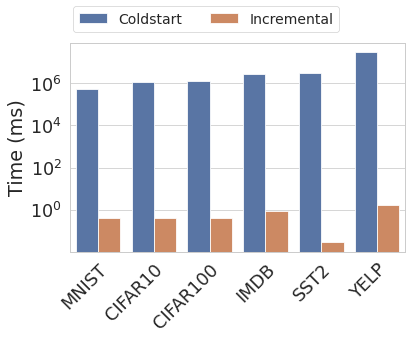

In [ ]:
ax = sns.barplot(x="dataset", y="value", hue="type", data=df_times)
plt.yscale("log")

ax.set_ylabel('Time (ms)')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()

f = plt.gcf()
f.legend(handles[0:], labels[0:], loc='upper center', ncol=4, prop={'size':14})
plt.subplots_adjust(top=0.85)

plt.savefig("{}.png".format('incremental'), bbox_inches = 'tight', pad_inches = 0.02)

# Taking the min

In [ ]:
columns = ["dataset", "embedding", "value"]
rows = []

embeddings = {
    'efficientnet_b4': 'EfficientNetB4',
     'pca_32': 'PCA(d=32)', 
     'xlnet': 'XLNet', 
     'use_large': 'USELarge'
     }

with open(path.join(directory, "errors_data.txt"), "r") as f:
    data = eval(f.read())

for dataset in modality.keys():

  num_classes_ = num_classes[dataset]

  for embedding, rename in embeddings.items():
    if embedding not in data[dataset].keys():
      continue

    score = ber(data[dataset][embedding]['test']['0.0']['1-NN cosine'][0], num_classes_)

    rows.append([dataset.split('_')[0].upper(), rename, score])

df_emb = pd.DataFrame(data=rows, columns=columns)
df_emb

,dataset,embedding,value
0,MNIST,EfficientNetB4,0.04
1,MNIST,PCA(d=32),0.02
2,CIFAR10,EfficientNetB4,0.05
3,CIFAR10,PCA(d=32),0.37
4,CIFAR100,EfficientNetB4,0.18
5,CIFAR100,PCA(d=32),0.55
6,IMDB,XLNet,0.11
7,IMDB,USELarge,0.18
8,SST2,XLNet,0.20
9,SST2,USELarge,0.15


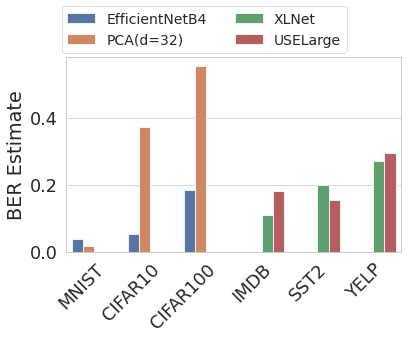

In [ ]:
ax = sns.barplot(x="dataset", y="value", hue="embedding", data=df_emb)
# plt.yscale("log")

ax.set_ylabel('BER Estimate')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()

f = plt.gcf()
f.legend(handles[0:], labels[0:], loc='upper center', ncol=2, prop={'size':14})
plt.subplots_adjust(top=0.8)

plt.savefig("{}.png".format('taking_min'), bbox_inches = 'tight', pad_inches = 0.02)

# Additional guidance

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, c):
  return np.exp(-1.0*a * np.log(x) + c)

def inv_func(y, a, c):
  return np.exp((np.log(y)-c)/(-1.0*a))

### Convergence Plots

Noise 0.2 Target 0.0 Required Samples: 83686931
Noise 0.2 Target 0.1 Required Samples: 310721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Noise 0.4 Target 0.0 Required Samples: 16450751
Noise 0.4 Target 0.1 Required Samples: 59429


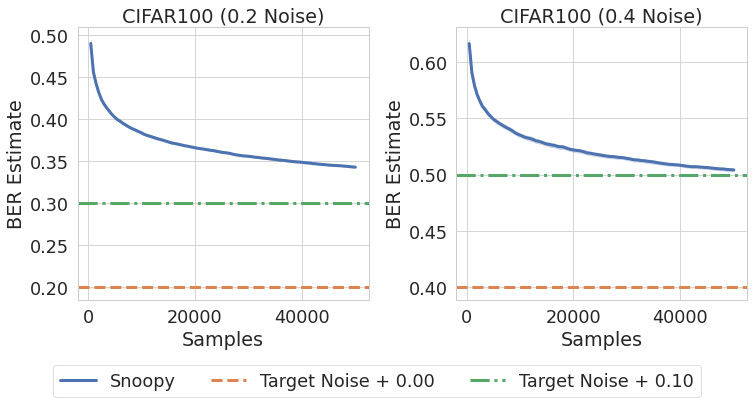

In [ ]:
dataset='cifar100'
emb='efficientnet_b5'
dimension=2048
# dataset='yelp'
# emb='use'
# dimension=512
# emb='xlnet'
# dimension=768
subsamples=101
noises=[0.2, 0.4]
targets=[0.0, 0.1]
styles = ['--', '-.']

f, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, noise in enumerate(noises):
  test_cnt = test_size[dataset]
  ax = axes[i]

  num_classes_ = num_classes[dataset]
  sota_ = sota[dataset]
  max_c = (num_classes_ - 1) / float(num_classes_)

  upper_bound = sota_ + noise * (max_c - sota_)
  lower_bound = noise * max_c

  # print("Reading", f'{dataset}-{emb}-errs-cosine-{noise}.npy')
  data = np.load(path.join(directory, f'{dataset}-{emb}-errs-cosine-{noise}.npy'))

  samples=data.shape[1]-1

  columns=['Samples', 'BER Estimate', 'Method']
  rows=[]

  x = []
  y = []

  for x_i in [math.ceil(j) for j in list(np.linspace(0, samples, subsamples))][1:]:
    x.append(x_i)
    ys = []
    for j in range(data.shape[0]):
      val=ber(data[j, x_i]/float(test_cnt), num_classes_)
      ys.append(val)
      rows.append([x_i, val, 'Snoopy'])
    y.append(np.mean(ys))

  df_convergence = pd.DataFrame(rows, columns=columns)

  sns.lineplot(data=df_convergence, ax=ax, x='Samples', y='BER Estimate', hue='Method', lw=3.0)
  # ax.axhline(y=upper_bound, color=colors[0], linestyle=styles[0], label=f'SOTA ({noise} Noise)')

  ax.set_title(f"{dataset.split('_')[0].upper()} ({noise} Noise)")

  popt, _ = curve_fit(func, x, y)
  for j, t in enumerate(targets):
    ax.axhline(y=noise+t, color=f"C{j+1}", lw=3.0, linestyle=styles[j], label=f'Target Noise + {t:.2f}')
    print("Noise", noise, "Target", t, "Required Samples:", math.ceil(inv_func(noise+t, *popt)))

  # ax.legend([],[], frameon=False)
  # ax.legend()

handles, lables = axes.flat[0].get_legend_handles_labels()

for i, ax in enumerate(axes.flat):
  ax.legend([],[], frameon=False)
for h in handles:
  if type(h) is not Line2D:
    h.set_sizes([200.0])
  if type(h) is Line2D:
    h.set_linewidth(3.0)

lgd = f.legend(flip(handles, ncol), flip(lables, ncol), loc='lower center', ncol=ncol)

plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.25)
save_filename = 'additional_guidance_plots'
f.savefig("{}.png".format(save_filename), bbox_inches = 'tight',
            bbox_extra_artists=(lgd,), pad_inches = 0)

### Extrapolation

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


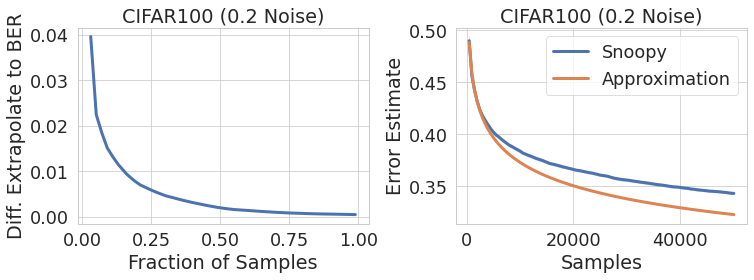

In [ ]:
dataset='cifar100'
emb='efficientnet_b5'
dimension=2048
subsamples=101
noise=0.2

f, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]

test_cnt = test_size[dataset]

num_classes_ = num_classes[dataset]
sota_ = sota[dataset]
max_c = (num_classes_ - 1) / float(num_classes_)

upper_bound = sota_ + noise * (max_c - sota_)
lower_bound = noise * max_c

# print("Reading", f'{dataset}-{emb}-errs-cosine-{noise}.npy')
data = np.load(path.join(directory, f'{dataset}-{emb}-errs-cosine-{noise}.npy'))

samples=data.shape[1]-1

columns=['Fraction of Samples', 'Diff. Extrapolate to BER']
rows=[]

x = []
y = []

for x_i in [math.ceil(j) for j in list(np.linspace(0, samples, subsamples))][1:]:
  x.append(x_i)
  ys = []
  for j in range(data.shape[0]):
    val=ber(data[j, x_i]/float(test_cnt), num_classes_)
    ys.append(val)
  y.append(np.mean(ys))

num=50
for frac in [(i+1)*(1.0/num) for i in range(num-1)]:
  to=math.ceil(len(x)*frac)
  popt, _ = curve_fit(func, x[:to], y[:to])

  pred = func(x[-1], *popt)
  rows.append([float(x[to])/samples, y[-1] - pred])

df_convergence = pd.DataFrame(rows, columns=columns)

sns.lineplot(data=df_convergence, ax=ax, x='Fraction of Samples', y='Diff. Extrapolate to BER', lw=3.0)

ax.set_title(f"{dataset.split('_')[0].upper()} ({noise} Noise)")

# Second part
ax = axes[1]
frac = 0.05
to=math.ceil(len(x)*frac)
popt, _ = curve_fit(func, x[:to], y[:to])

columns=['Samples', 'Error Estimate', 'Method']
rows = []


for x_i in [math.ceil(j) for j in list(np.linspace(0, samples, subsamples))][1:]:
  for j in range(data.shape[0]):
    val=ber(data[j, x_i]/float(test_cnt), num_classes_)
    rows.append([x_i, val, 'Snoopy'])
    rows.append([x_i, func(x_i, *popt), f'Approximation'])

df_convergence = pd.DataFrame(rows, columns=columns)

sns.lineplot(data=df_convergence, ax=ax, x='Samples', y='Error Estimate', lw=3.0,
             hue='Method')

handles, lables = ax.get_legend_handles_labels()
for h in handles:
  if type(h) is Line2D:
    h.set_linewidth(3.0)

ax.legend(handles[0:], lables[0:])

ax.set_title(f"{dataset.split('_')[0].upper()} ({noise} Noise)")

plt.subplots_adjust(wspace=0.3, hspace=0.4, bottom=0.2)
save_filename = 'additional_guidance_extrapolate'
f.savefig("{}.png".format(save_filename), bbox_inches = 'tight', pad_inches = 0)